We will work on this notebook to implement the algorithm.
Please check regularly for updates.

Main tasks:
1. Write the code for the algorithm
2. Find better $\alpha$ and $\beta$ values for the model.
3. Find stopping criteria for the model.
4. Apply the new hyperparameters to the algorithm, and evaluate the results on a lexical similarity task, then on a sentiment analysis task.

In [1]:
# Importing the libraries:
import numpy as np
import gensim.models.word2vec as w2v
import gensim.downloader as api
import math
import re
from copy import deepcopy
import sys
import gzip
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt


In [2]:
# Toy corpus of 10 words:
toy_corpus = ['frog', 'toad', 'berger', 'cat', 'cheetah', 'dog', 'feline', 'true', 'false', 'incorrect']

In [22]:
# Load the word2vec model:
wv = api.load('word2vec-google-news-300')
#wv = w2v.Word2Vec(vector_size=250, min_count=500, window=8, sample=1e-3, workers=8, sg=1, hs=0, negative=10, epochs=5)

TypeError: load() got an unexpected keyword argument 'limit'

In [4]:
# Vectorize the toy corpus:
#vec_toy_corpus = [wv.wv[word] for word in toy_corpus]
vec_toy_corpus = [wv[word] for word in toy_corpus]

In [5]:
# Compare vectors using cosine similarity:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Compute the cosine similarity matrix:
similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        similarity_matrix[i][j] = cosine_similarity(vec_toy_corpus[i], vec_toy_corpus[j])

# Print the cosine similarity matrix:
for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        print(f'Similarity between {toy_corpus[i]} and {toy_corpus[j]} is {similarity_matrix[i][j]:.4f}')

Similarity between frog and frog is 1.0000
Similarity between frog and toad is 0.7050
Similarity between frog and berger is 0.1045
Similarity between frog and cat is 0.4789
Similarity between frog and cheetah is 0.4109
Similarity between frog and dog is 0.3550
Similarity between frog and feline is 0.3681
Similarity between frog and true is 0.1128
Similarity between frog and false is -0.0008
Similarity between frog and incorrect is 0.0589
Similarity between toad and frog is 0.7050
Similarity between toad and toad is 1.0000
Similarity between toad and berger is 0.1365
Similarity between toad and cat is 0.4725
Similarity between toad and cheetah is 0.4156
Similarity between toad and dog is 0.3837
Similarity between toad and feline is 0.4253
Similarity between toad and true is 0.0903
Similarity between toad and false is 0.0358
Similarity between toad and incorrect is 0.0119
Similarity between berger and frog is 0.1045
Similarity between berger and toad is 0.1365
Similarity between berger a

# 1. Implementing the algorithm and finding the best hyperparameters.

In [64]:
# We implement the retrofitting algorithm of Faruqui et al. (2015):
# Preprocessing the data:
isNumber = re.compile(r'\d+.*')
def norm_word(word):
  if isNumber.search(word.lower()):
    return '---num---'
  elif re.sub(r'\W+', '', word) == '':
    return '---punc---'
  else:
    return word.lower()

# Read all the word vectors and normalize them:
def read_word_vecs(filename):
  wordVectors = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r')
  
  for line in fileObject:
    line = line.strip().lower()
    word = line.split()[0]
    wordVectors[word] = np.zeros(len(line.split())-1, dtype=float)
    for index, vecVal in enumerate(line.split()[1:]):
      wordVectors[word][index] = float(vecVal)
    ''' normalize weight vector '''
    wordVectors[word] /= math.sqrt((wordVectors[word]**2).sum() + 1e-6)
    
  sys.stderr.write("Vectors read from: "+filename+" \n")
  return wordVectors

# Read lexicon as a dictionary:
def read_lexicon(filename):
  lexicon = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r')
  
  for line in fileObject:
    words = line.lower().strip().split()
    lexicon[norm_word(words[0])] = [norm_word(word) for word in words[1:]]
  return lexicon

# Retrofit word vectors to a lexicon:
def retrofit(wordVecs, lexicon, numIters, alpha = 1, beta = 2): # wordVecs is a dictionary
  newWordVecs = deepcopy(wordVecs)
  wvVocab = set(newWordVecs.keys())
  loopVocab = wvVocab.intersection(set(lexicon.keys()))
  for it in range(numIters):
    # loop through every node also in ontology (else just use data estimate)
    for word in loopVocab:
      wordNeighbours = set(lexicon[word]).intersection(wvVocab)
      numNeighbours = len(wordNeighbours)
      #no neighbours, pass - use data estimate
      if numNeighbours == 0:
        continue
      # the weight of the old vector is alpha
      newVec = alpha * wordVecs[word]
      # loop over neighbours and add to new vector (currently with weight beta)
      for ppWord in wordNeighbours:
        newVec += beta * newWordVecs[ppWord] 
      newWordVecs[word] = newVec/(alpha + beta) 
  return newWordVecs

In [65]:
# Transform the toy corpus into a wordVecs dictionary:
toy_wordVecs = {}
for i in range(len(vec_toy_corpus)):
    toy_wordVecs[toy_corpus[i]] = vec_toy_corpus[i]
print(toy_wordVecs.keys())

dict_keys(['frog', 'toad', 'berger', 'cat', 'cheetah', 'dog', 'feline', 'true', 'false', 'incorrect'])


In [66]:
# Read the lexicon. We can use NLTK WordNet.
lexicon = {}
# The idea is to create a dictionary where the keys are the words in the corpus
# and the values are the words that are related to the key word from the WordNet.
for synset in wn.all_synsets():
    for lemma in synset.lemmas():
        word = lemma.name()
        if word not in lexicon:
            lexicon[word] = []
        for related_synset in synset.hyponyms() + synset.hypernyms() + synset.part_meronyms() + synset.part_holonyms() + synset.member_holonyms() + synset.member_meronyms():
            for related_lemma in related_synset.lemmas():
                related_word = related_lemma.name()
                if related_word != word:
                    lexicon[word].append(related_word)


In [67]:
# We can take a peek at the lexicon too:
print(lexicon['cat'])

['domestic_cat', 'house_cat', 'Felis_domesticus', 'Felis_catus', 'wildcat', 'feline', 'felid', 'cheetah', 'chetah', 'Acinonyx_jubatus', 'jaguar', 'panther', 'Panthera_onca', 'Felis_onca', 'leopard', 'Panthera_pardus', 'liger', 'lion', 'king_of_beasts', 'Panthera_leo', 'saber-toothed_tiger', 'sabertooth', 'snow_leopard', 'ounce', 'Panthera_uncia', 'tiger', 'Panthera_tigris', 'tiglon', 'tigon', 'feline', 'felid', 'Felidae', 'family_Felidae', 'tracked_vehicle', 'whip', 'stimulant', 'stimulant_drug', 'excitant', 'gossip', 'gossiper', 'gossipmonger', 'rumormonger', 'rumourmonger', 'newsmonger', 'woman', 'adult_female', 'sod', 'man', 'adult_male', 'excrete', 'egest', 'eliminate', 'pass', 'flog', 'welt', 'whip', 'lather', 'lash', 'slash', 'strap', 'trounce']


In [68]:
# Retrofit the word vectors using basic hyperparameters:
newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = 10, alpha = 1, beta = 2)

# Similarity matrix after retrofitting:
retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
        
# Print the cosine similarity matrix:
for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        print(f'Similarity is changed by {retro_similarity_matrix[i][j] - similarity_matrix[i][j]:.4f} between {toy_corpus[i]} and {toy_corpus[j]}')

print(f'Similarity is changed by {retro_similarity_matrix[3][6] - similarity_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
print(f'Similarity is changed by {retro_similarity_matrix[2][5] - similarity_matrix[2][5]:.4f} between {toy_corpus[2]} and {toy_corpus[5]}')
print(f'Similarity is changed by {retro_similarity_matrix[3][4] - similarity_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')

print('There has been some improvements in the toy corpus! We can move on to find the better hyperparameters.')

Similarity is changed by 0.0000 between frog and frog
Similarity is changed by 0.0000 between frog and toad
Similarity is changed by 0.0000 between frog and berger
Similarity is changed by 0.0274 between frog and cat
Similarity is changed by 0.0973 between frog and cheetah
Similarity is changed by 0.0000 between frog and dog
Similarity is changed by 0.1311 between frog and feline
Similarity is changed by 0.0000 between frog and true
Similarity is changed by 0.0000 between frog and false
Similarity is changed by 0.0000 between frog and incorrect
Similarity is changed by 0.0000 between toad and frog
Similarity is changed by 0.0000 between toad and toad
Similarity is changed by 0.0000 between toad and berger
Similarity is changed by 0.0517 between toad and cat
Similarity is changed by 0.1095 between toad and cheetah
Similarity is changed by 0.0000 between toad and dog
Similarity is changed by 0.0961 between toad and feline
Similarity is changed by 0.0000 between toad and true
Similarity i

Alpha is 0.1
Similarity is changed by 0.2674 between cat and feline
Similarity is changed by 0.5220 between cat and cheetah
Alpha is 0.4
Similarity is changed by 0.2674 between cat and feline
Similarity is changed by 0.5220 between cat and cheetah
Alpha is 0.7
Similarity is changed by 0.2673 between cat and feline
Similarity is changed by 0.5217 between cat and cheetah
Alpha is 1.0
Similarity is changed by 0.2660 between cat and feline
Similarity is changed by 0.5188 between cat and cheetah
Alpha is 1.3
Similarity is changed by 0.2621 between cat and feline
Similarity is changed by 0.5104 between cat and cheetah
Alpha is 1.6
Similarity is changed by 0.2560 between cat and feline
Similarity is changed by 0.4974 between cat and cheetah
Alpha is 1.9
Similarity is changed by 0.2489 between cat and feline
Similarity is changed by 0.4821 between cat and cheetah
Alpha is 2.2
Similarity is changed by 0.2415 between cat and feline
Similarity is changed by 0.4661 between cat and cheetah
Alpha is

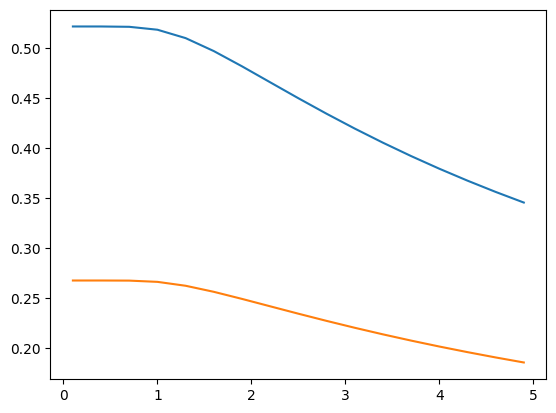

The best alpha is 1 for feline and 1 for cheetah


In [69]:
# Test different hyperparameters:
# Test alpha:
improvement_cheetah = []
improvement_feline = []
for alpha in np.arange(0.1, 5.1, 0.3):
    newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = 10, alpha = alpha, beta = 2)
    retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
    for i in range(len(vec_toy_corpus)):
        for j in range(len(vec_toy_corpus)):
            retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
    print(f'Alpha is {alpha:.1f}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][6] - similarity_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][4] - similarity_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')
    improvement_feline.append(retro_similarity_matrix[3][6] - similarity_matrix[3][6])
    improvement_cheetah.append(retro_similarity_matrix[3][4] - similarity_matrix[3][4])

# Plot the results:
plt.plot(np.arange(0.1, 5.1, 0.3), improvement_cheetah, label = 'cheetah')
plt.plot(np.arange(0.1, 5.1, 0.3), improvement_feline, label = 'feline')
plt.show()
print(f"The best alpha is {np.argmax(improvement_feline) + 1} for feline and {np.argmax(improvement_cheetah) + 1} for cheetah")

Beta is 1
Similarity is changed by 0.2465 between cat and feline
Similarity is changed by 0.4768 between cat and cheetah
Beta is 2
Similarity is changed by 0.2660 between cat and feline
Similarity is changed by 0.5188 between cat and cheetah
Beta is 3
Similarity is changed by 0.2673 between cat and feline
Similarity is changed by 0.5218 between cat and cheetah
Beta is 4
Similarity is changed by 0.2674 between cat and feline
Similarity is changed by 0.5220 between cat and cheetah
Beta is 5
Similarity is changed by 0.2674 between cat and feline
Similarity is changed by 0.5220 between cat and cheetah
Beta is 6
Similarity is changed by 0.2674 between cat and feline
Similarity is changed by 0.5220 between cat and cheetah
Beta is 7
Similarity is changed by 0.2674 between cat and feline
Similarity is changed by 0.5220 between cat and cheetah
Beta is 8
Similarity is changed by 0.2674 between cat and feline
Similarity is changed by 0.5220 between cat and cheetah
Beta is 9
Similarity is changed 

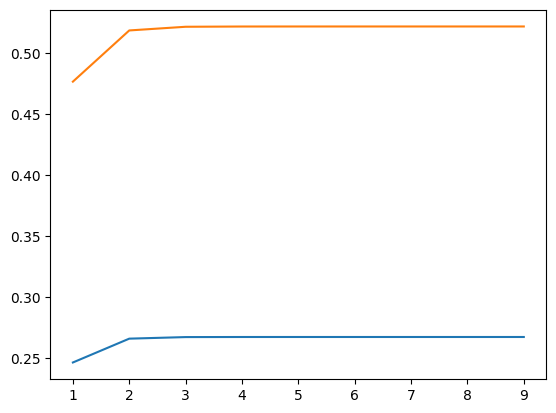

The best beta is 9 for feline and 9 for cheetah


In [70]:
# Test beta:
improvement_feline = []
improvement_cheetah = []
for beta in range(1, 10):
    newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = 10, alpha = 1, beta = beta)
    retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
    for i in range(len(vec_toy_corpus)):
        for j in range(len(vec_toy_corpus)):
            retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
    improvement_feline.append(retro_similarity_matrix[3][6] - similarity_matrix[3][6])
    improvement_cheetah.append(retro_similarity_matrix[3][4] - similarity_matrix[3][4])
    print(f'Beta is {beta}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][6] - similarity_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][4] - similarity_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')

# Plot the results:
plt.plot(range(1, 10), improvement_feline, label = 'feline')
plt.plot(range(1, 10), improvement_cheetah, label = 'cheetah')
plt.show()
print(f"The best beta is {np.argmax(improvement_feline) + 1} for feline and {np.argmax(improvement_cheetah) + 1} for cheetah")

Number of iterations is 1
Similarity is changed by 0.2615 between cat and feline
Similarity is changed by 0.4600 between cat and cheetah
Number of iterations is 2
Similarity is changed by 0.2630 between cat and feline
Similarity is changed by 0.5049 between cat and cheetah
Number of iterations is 3
Similarity is changed by 0.2640 between cat and feline
Similarity is changed by 0.5108 between cat and cheetah
Number of iterations is 4
Similarity is changed by 0.2646 between cat and feline
Similarity is changed by 0.5138 between cat and cheetah
Number of iterations is 5
Similarity is changed by 0.2651 between cat and feline
Similarity is changed by 0.5156 between cat and cheetah
Number of iterations is 6
Similarity is changed by 0.2654 between cat and feline
Similarity is changed by 0.5167 between cat and cheetah
Number of iterations is 7
Similarity is changed by 0.2656 between cat and feline
Similarity is changed by 0.5175 between cat and cheetah
Number of iterations is 8
Similarity is c

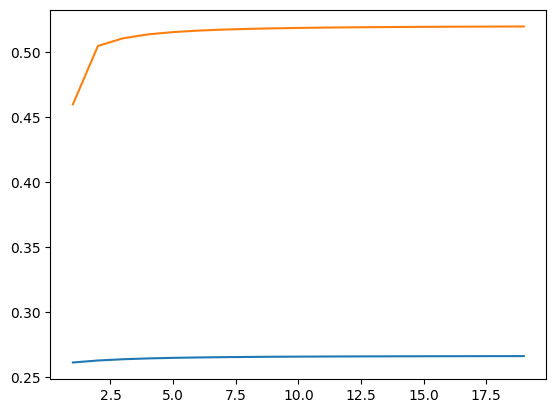

The best number of Iteration is 19 for feline and 19 for cheetah


In [71]:
# Test number of iterations:
improvement_feline = []
improvement_cheetah = []
for iter in range(1, 20):
    newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = iter, alpha = 1, beta = 2)
    retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
    for i in range(len(vec_toy_corpus)):
        for j in range(len(vec_toy_corpus)):
            retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
    improvement_feline.append(retro_similarity_matrix[3][6] - similarity_matrix[3][6])
    improvement_cheetah.append(retro_similarity_matrix[3][4] - similarity_matrix[3][4])
    print(f'Number of iterations is {iter}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][6] - similarity_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][4] - similarity_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')

# Plot the results:
plt.plot(range(1, 20), improvement_feline, label = 'feline')
plt.plot(range(1, 20), improvement_cheetah, label = 'cheetah')
plt.show()
print(f"The best number of Iteration is {np.argmax(improvement_feline) + 1} for feline and {np.argmax(improvement_cheetah) + 1} for cheetah")

From these results, we can see that the performance of the retrofitting algorithm works best with this set of hyperparameters: alpha = 1, beta = 2, and nb_iter = 7, because the performance does not increase significantly when these hyperparameters are increased.

# 2. Implement the algorithm in matrix form.

In order to implement the retrofitting algorithm in the matrix form, we will assume that the input is the whole word embeddings matrix E(w), and the output is the whole word embeddings matrix E'(w). The retrofitting algorithm will be applied to the whole word embeddings matrix E(w) to get the whole word embeddings matrix E'(w).

To do this, we will have to change the way the lexicon works. At the moment, it is a dictionary with words as keys and their neighbors as values, but to have better performance on a larger vocabulary, it should have indices instead of words. This way, we can use the indices to access the word embeddings matrix E(w) and E'(w).

In [84]:
# Word ids and indices:
word_ids = wv.key_to_index
word_indices = wv.index_to_key


In [113]:
# Take a look at the lexicon:
print(word_ids['Great_Pyrenees'])
print(lexicon['Great_Pyrenees'])

268633
['dog', 'domestic_dog', 'Canis_familiaris']


In [120]:
# Create a new dictionary to store the lexicon with word IDs
# This dictionary will have as keys the word IDs and as values the list of IDs of the words in the lexicon that are related to the key. The words not present in the vocabulary are ignored.
# This is done to ensure that the IDs of the words in the lexicon are the same as the IDs of the words in the vocabulary.
lexicon_with_ids = {}

# Using the same method as above, but this time we are using the word IDs instead of the words themselves
for synset in wn.all_synsets():
    for lemma in synset.lemmas():
        word = lemma.name()
        if word not in word_ids:
            continue
        if word not in lexicon_with_ids:
            lexicon_with_ids[word_ids[word]] = []
        for related_synset in synset.hyponyms() + synset.hypernyms() + synset.part_meronyms() + synset.part_holonyms() + synset.member_holonyms() + synset.member_meronyms():
            for related_lemma in related_synset.lemmas():
                related_word = related_lemma.name()
                if related_word in word_ids:
                    if related_word != word:
                        lexicon_with_ids[word_ids[word]].append(word_ids[related_word])

In [127]:
# Test new lexicon:
print(lexicon_with_ids.keys()) # List of word IDs
print(lexicon_with_ids.get(268633)) # Great_Pyrenees

dict_keys([346, 2267, 168062, 267681, 38640, 21913, 51782, 3423, 5697, 37374, 64, 89581, 529, 14920, 52904, 195354, 65154, 6605, 1540, 27878, 141478, 28069, 963, 4051, 17449, 71376, 92844, 359871, 95505, 946860, 603233, 19829, 86471, 872488, 30391, 1731173, 59518, 10543, 447920, 1246835, 264063, 1708213, 355653, 169272, 119879, 1612750, 37065, 81913, 127313, 86459, 671871, 73680, 54063, 480100, 18358, 1264207, 368337, 86109, 137621, 849377, 15838, 1073696, 954147, 48975, 22879, 3966, 12906, 1539645, 4228, 4591, 591, 10694, 13784, 141075, 35445, 10727, 59742, 899015, 18855, 2242, 43943, 993, 29605, 21073, 154790, 169150, 70182, 6413, 180, 347935, 1685689, 18843, 12243, 5593, 1056665, 31143, 116745, 78629, 13118, 2612, 2422, 8105, 155780, 29068, 8319, 5788, 72444, 512445, 127565, 315243, 7352, 1555148, 21682, 5540, 37573, 46692, 11610, 25746, 758605, 62806, 3456, 1232196, 97868, 374452, 87051, 963463, 153367, 60361, 222052, 22139, 60394, 568210, 68448, 611631, 1020442, 40046, 3989, 398, 

In [134]:
# Create the embedding matrix:
# It works if we have enough RAM
embedding_matrix = np.zeros((len(word_indices), 300))
for i in range(len(word_indices)):
    embedding_matrix[i] = wv[word_indices[i]]   

MemoryError: Unable to allocate 6.71 GiB for an array with shape (3000000, 300) and data type float64

In [133]:
# Create a neighbor matrix from the new lexicon:
# The value for each word is the sum of the embeddings of the words in the lexicon that are related to the word
neighbor_matrix = np.zeros((len(word_indices), 300)) # It's a matrix of size (vocab_size, 300)
for i in range(len(word_indices)):
    if len(lexicon_with_ids[i]) == 0:
        continue
    for j in range(len(lexicon_with_ids[i])):
        neighbor_matrix[i] += wv[lexicon_with_ids[i][j]]

MemoryError: Unable to allocate 6.71 GiB for an array with shape (3000000, 300) and data type float64

In [ ]:
# Define the retrofitting algorithm, using the previously found hyperparameters:
def retrofit_matrix(embedding_matrix, neighbor_matrix, alpha = 1, beta = 2, nb_iters = 7):
    new_embedding_matrix = embedding_matrix
    for i in range(nb_iters):
        new_embedding_matrix = (alpha * new_embedding_matrix + beta * neighbor_matrix) / (alpha + beta)
    return new_embedding_matrix

# Run the algorithm on the Google News 300 embedding matrix:
retrofitted_matrix = retrofit_matrix(embedding_matrix, neighbor_matrix)

# 3. Evaluations.
We will evaluate the new retrofitted word embeddings on a lexical similarity task, and a sentiment analysis task.
## 3.1. Lexical similarity task.
We will use the WordSim353 dataset to evaluate the performance of the retrofitting algorithm on a lexical similarity task. The WordSim353 dataset contains 353 pairs of words, and each pair is assigned a similarity score by human annotators. The similarity score ranges from 0 to 10, with 0 being not similar at all, and 10 being very similar. We will use the cosine similarity between the word embeddings of each pair of words to calculate the similarity score, and then compare it with the human similarity score to see how well the retrofitting algorithm performs. (it's just nonsense that Copilot generated, I will rewrite it later)

## 3.2. Sentiment analysis task.
We will use the Stanford Sentiment Treebank dataset to evaluate the performance of the retrofitting algorithm on a sentiment analysis task. The Stanford Sentiment Treebank dataset contains 11,855 sentences, and each sentence is assigned a sentiment score by human annotators. The sentiment score ranges from 0 to 4, with 0 being very negative, and 4 being very positive. We will use the cosine similarity between the word embeddings of each sentence to calculate the sentiment score, and then compare it with the human sentiment score to see how well the retrofitting algorithm performs. (it's just nonsense that Copilot generated, I will rewrite it later)